In [1]:
!pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 513.5 kB/s eta 0:00:00a 0:00:01
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
"""
Datasketch provides efficient algorithms and data structures to handle large datasets where exact solutions
might be too resource-intensive. Key features include implementations of MinHash for estimating
"""
from datasketch import MinHash, MinHashLSH
import pandas as pd

In [4]:
basket_data = pd.read_csv("/content/basket-data-tiny.csv", header=None)
basket_data.columns = ["UserId", "Date", "ItemName"]

FileNotFoundError: [Errno 2] No such file or directory: '/content/basket-data-tiny.csv'

In [15]:
basket_data.head()

,UserId,Date,ItemName
0,1000,15-03-2015,sausage
1,1000,15-03-2015,semi-finished bread
2,1000,15-03-2015,whole milk
3,1000,15-03-2015,yogurt
4,1000,24-06-2014,pastry


In [16]:
basket_data.UserId.value_counts()

UserId
1004    21
1013    19
1006    15
1000    13
1011    13
1008    12
1001    12
1010    12
1012    11
1016    11
1017    11
1014    10
1009     9
1003     8
1002     8
1015     7
1005     4
1018     4
Name: count, dtype: int64

In [17]:
basket_data.ItemName.value_counts()

ItemName
whole milk          17
rolls/buns          17
yogurt               9
frankfurter          8
other vegetables     7
                    ..
liver loaf           1
white wine           1
newspapers           1
ketchup              1
beverages            1
Name: count, Length: 82, dtype: int64

### MinHash Example

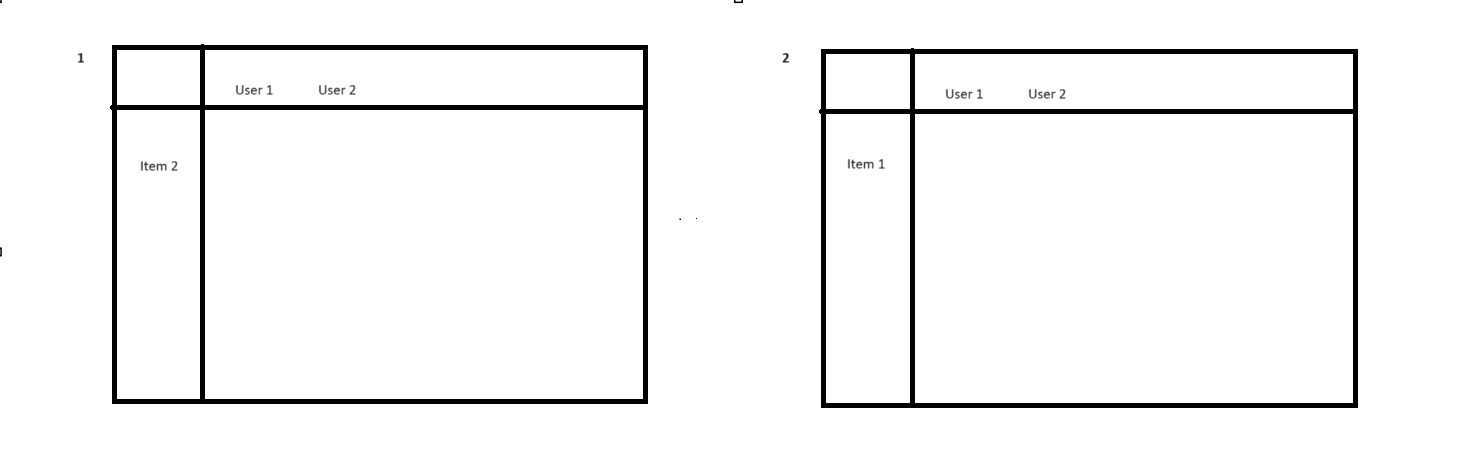

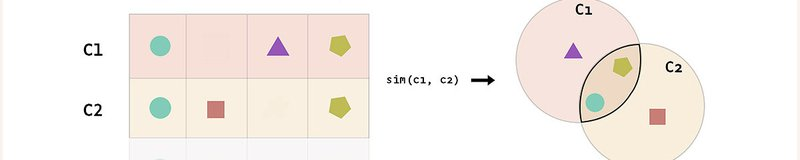

In [ ]:
"""
But the problem is we'd have to redo this for every new user.
So we need something that approximates the item permutation.
"""

In [18]:
user_minhashes = {}
user_sets = basket_data.groupby('UserId')['ItemName'].apply(set)

for user_id, items in user_sets.items():
  # number of hash functions = number of permutations
    m = MinHash(num_perm=128)  # 128 hash functions: fixed across users but getting refined to recalculate the values
    for item in items:
        m.update(item.encode('utf8'))  # Update MinHash with each item
    user_minhashes[user_id] = m

## The idea remains the same, what is the min value across all the items
- e.g. if we could represent a permutation as a function

In [ ]:
"""
Instead of permuting and then finding the min across all items, we say what is the min hash value across all items
"""

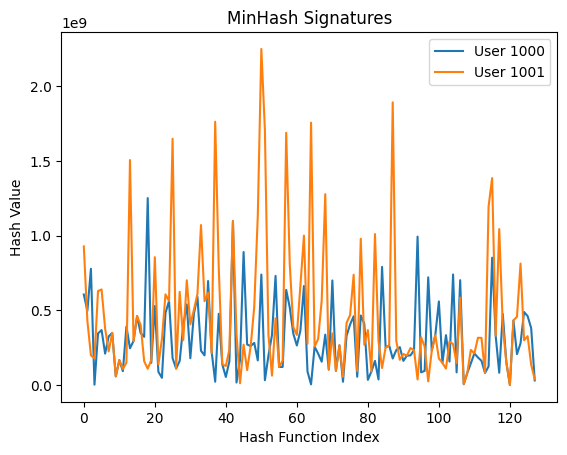

In [20]:
import matplotlib.pyplot as plt

# Pick a few user IDs to inspect
sample_users = list(user_minhashes.keys())[:2]

# Plotting the signatures
for user_id in sample_users:
    plt.plot(user_minhashes[user_id].hashvalues, label=f'User {user_id}')
plt.title('MinHash Signatures')
plt.xlabel('Hash Function Index')
plt.ylabel('Hash Value')
plt.legend()
plt.show()


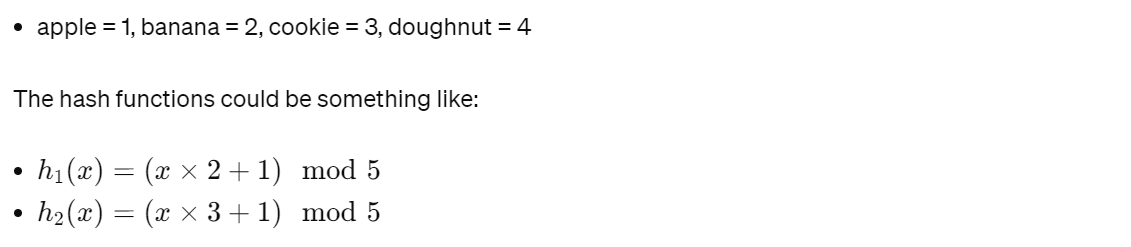

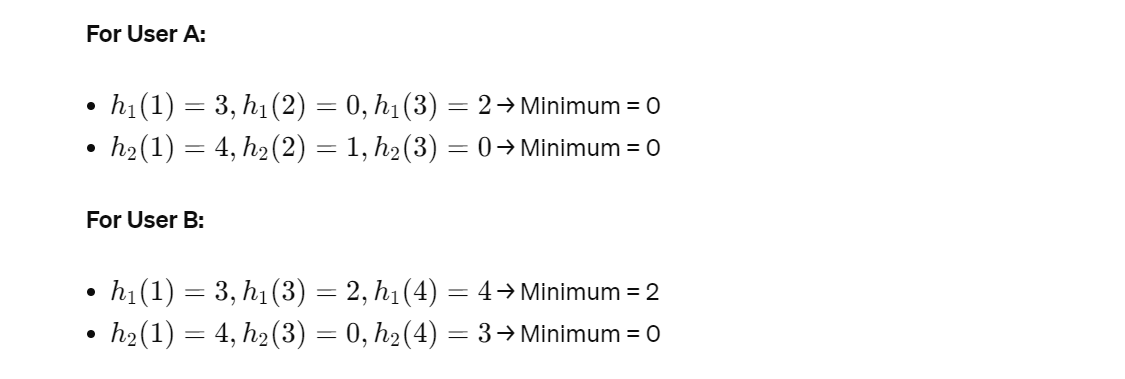

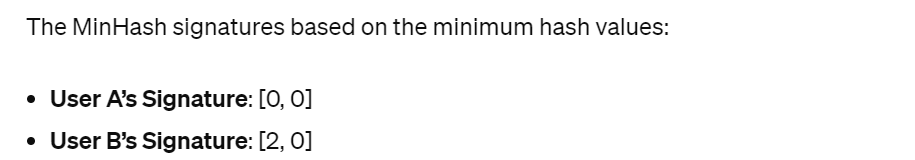

In [ ]:
user1_id, user2_id = 1000, 1002

u1_m = user_minhashes[user1_id]
u2_m = user_minhashes[user2_id]
estimated_jaccard_similarity = u1_m.jaccard(u2_m)

print(f"Estimated Jaccard similarity between user1 and user2: {estimated_jaccard_similarity}")

Estimated Jaccard similarity between user1 and user2: 0.0546875


In [ ]:
def actual_jaccard(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if len(union) > 0 else 0

actual_similarity = actual_jaccard(user_sets[user1_id], user_sets[user2_id])
print(f"Actual Jaccard similarity between user1 and user2: {actual_similarity}")

Actual Jaccard similarity between user1 and user2: 0.05555555555555555


### MinHashLSH Example

In [ ]:
"""
LSH uses multiple hash functions designed to maximize the probability that similar items hash to the same value.
These functions are constructed so that the probability of a collision (items hashing to the same value) is higher for items that
are more similar
"""

In [ ]:
# e.g. Each hash function is defined by a random hyperplane.
# The side of the hyperplane on which a vector (item) falls determines the hash value (0 or 1).

In [ ]:
# Initialize MinHash LSH
"""
The higher the threshold the stronger is the criteria for matching two users
"""
lsh = MinHashLSH(threshold=0.15, num_perm=128)
user_minhashes = {}

for user_id, items in user_sets.items():
    m = MinHash(num_perm=128)  # 128 hash functions
    for item in items:
        m.update(item.encode('utf8'))  # Update MinHash with each item
    lsh.insert(user_id, m)
    user_minhashes[user_id] = m

# Query to find similar user
query_user = 1002
query_user_minhash = user_minhashes[query_user]
result = lsh.query(query_user_minhash)
print("Similar users to {query_user}:", result)

Similar users to {query_user}: [1002, 1004, 1012, 1013, 1014]
